In [68]:
import pandas as pd
import numpy as np
import os
import cv2,random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
dataset =( "/content/drive/MyDrive/P8-DATA/traffic_Data/DATA")
epochs = 10
batch_size = 29

In [71]:
path1 = '/content/drive/MyDrive/P8-DATA/labels.csv'
df = pd.read_csv(path1)

In [72]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import splitfolders
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# train_generator = datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(128, 128),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='training',
#     shuffle=True)

# valid_generator = datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(128, 128),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='validation',
#     shuffle=True)
############################### (.flow_from_directory can be used only if you have separate train and validation files 
############################### with thier sub label folders 
############################### otherwise use image_dataset_from_directory.)

splitfolders.ratio(dataset, output="output", seed=1337, ratio=(.8, 0.1,0.1))

train_generator = tf.keras.utils.image_dataset_from_directory("/content/output/train",
                                                    image_size=(56,56),
                                                    seed=123,
                                                    batch_size=32)

valid_generator = tf.keras.utils.image_dataset_from_directory("/content/output/val",
                                                    image_size=(56,56),
                                                    seed=123,
                                                    batch_size=32)

test_generator = tf.keras.utils.image_dataset_from_directory("/content/output/test",
                                                    image_size=(56,56),
                                                    seed=123,
                                                    batch_size=32)

 


Copying files: 4170 files [00:18, 221.87 files/s]


Found 3313 files belonging to 58 classes.
Found 394 files belonging to 58 classes.
Found 463 files belonging to 58 classes.


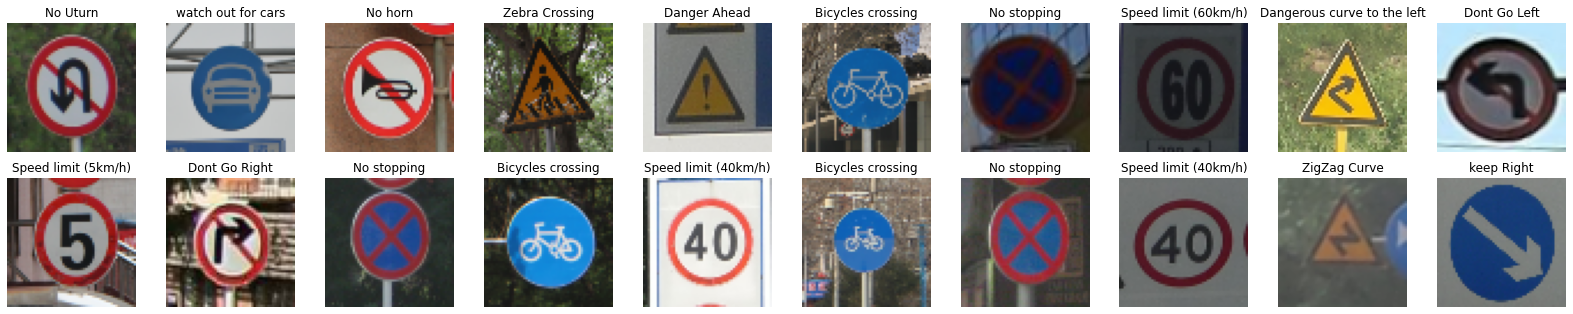

In [74]:
class_numbers = test_generator.class_names
class_names = []
for i in class_numbers:
 class_names.append(df['Name'][int(i)])

#class_names
plt.figure(figsize=(28, 28))
for images, labels in test_generator.take(1):
  for i in range(20):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()


In [75]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(56,56,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical")
  ]
)

In [76]:
model=keras.Sequential(
    [
        keras.Input(shape=(56,56,3)),
        #data_augmentation,
        layers.Rescaling(1./255),
        layers.Flatten(input_shape=(56,56,3)),
        layers.Dense(256,activation='relu',name="layer1"),
        layers.Dropout(0.2),
        layers.Dense(128,activation='relu',name="layer2"),
        layers.Dense(58,activation='softmax',name="output")
    ]
)

print(model.summary())

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 56, 56, 3)         0         
                                                                 
 flatten_21 (Flatten)        (None, 9408)              0         
                                                                 
 layer1 (Dense)              (None, 256)               2408704   
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 layer2 (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 58)                7482      
                                                                 
Total params: 2,449,082
Trainable params: 2,449,082
N

In [77]:
history=model.fit(
    train_generator,
    validation_data=valid_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=100,verbose=1
)


Epoch 1/100
104/104 [==============================] - 4s 34ms/step - loss: 3.3745 - accuracy: 0.1983 - val_loss: 2.8309 - val_accuracy: 0.2741
Epoch 2/100
104/104 [==============================] - 4s 33ms/step - loss: 2.6825 - accuracy: 0.3535 - val_loss: 2.2844 - val_accuracy: 0.4365
Epoch 3/100
104/104 [==============================] - 4s 33ms/step - loss: 2.2471 - accuracy: 0.4567 - val_loss: 1.8714 - val_accuracy: 0.5533
Epoch 4/100
104/104 [==============================] - 4s 33ms/step - loss: 1.9257 - accuracy: 0.5442 - val_loss: 1.5802 - val_accuracy: 0.6091
Epoch 5/100
104/104 [==============================] - 4s 33ms/step - loss: 1.6891 - accuracy: 0.6049 - val_loss: 1.3875 - val_accuracy: 0.6878
Epoch 6/100
104/104 [==============================] - 4s 33ms/step - loss: 1.4795 - accuracy: 0.6493 - val_loss: 1.1398 - val_accuracy: 0.7360
Epoch 7/100
104/104 [==============================] - 4s 33ms/step - loss: 1.3101 - accuracy: 0.6936 - val_loss: 1.0082 - val_accuracy:

In [78]:
pred = np.argmax(model.predict(test_generator), axis=-1)
score, accuracy = model.evaluate(test_generator)
print('loss in testing set is:',score,'\naccuracy of testing set:',accuracy*100,'%')

15/15 [==============================] - 0s 15ms/step - loss: 0.0387 - accuracy: 0.9957
loss in testing set is: 0.03871138021349907 
accuracy of testing set: 99.56803321838379 %


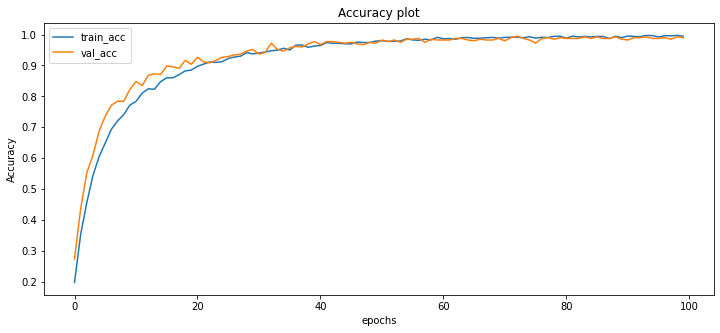

In [79]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy plot')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()